In [1284]:
# Data handling
import numpy as np
import pandas as pd
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline

# Stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import shapiro, norm, chi2_contingency, kstest, boxcox
from scipy.stats.contingency import association



# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, Normalizer


#lib
from lib.clean_data_functions import clean_ext_version, clean_ext_publisher, clean_repo_publisher
from lib.eda_functions import detect_iqr_outliers,detect_winsor_outliers

#
from ast import literal_eval
from collections import Counter

# os
import os

# time
import time

import warnings
warnings.filterwarnings("ignore")    # (Optional)

print("Project has been created with Pandas: " ,pd. __version__," And with Numpy: ",np. __version__)

Project has been created with Pandas:  2.3.1  And with Numpy:  2.3.2


In [1285]:
import yaml

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

### Loading

In [1286]:
df = pd.read_csv(config["data"]["clean"]["file_data_cleaned"])
df.head()

,ext_version,ext_categories,ext_install_count,ext_rating,verified,repository,total_vulners,critical_vulners,high_vulners,medium_vulners,low_vulners,repo_owner,repo_name,repo_stars,repo_forks,repo_languages
0,2025,Programming Languages;Debuggers;Data Science;M...,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,typescript;python;javascript;jupyter notebook;...
1,2025,Programming Languages,146473811,3.01,True,https://github.com/microsoft/pylance-release,0,0,0,0,0,microsoft,pylance-release,1882,856,python;jupyter notebook
2,2025,Extension Packs;Data Science;Machine Learning;...,93931981,2.70,True,https://github.com/Microsoft/vscode-jupyter,0,0,0,0,0,Microsoft,vscode-jupyter,1401,337,typescript;python;jupyter notebook;javascript;...
3,1,Programming Languages;Snippets;Linters;Debugge...,85413454,3.43,True,https://github.com/Microsoft/vscode-cpptools,11,0,0,0,11,Microsoft,vscode-cpptools,5873,1633,typescript;c++;html;javascript
4,1,Notebooks,74084334,4.00,True,https://github.com/Microsoft/vscode-jupyter-ke...,17,0,0,9,8,Microsoft,vscode-jupyter-keymap,32,14,unknown


In [1287]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 19553 rows and 16 columns


In [1288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19553 entries, 0 to 19552
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ext_version        19553 non-null  int64  
 1   ext_categories     19553 non-null  object 
 2   ext_install_count  19553 non-null  int64  
 3   ext_rating         19553 non-null  float64
 4   verified           19553 non-null  bool   
 5   repository         19553 non-null  object 
 6   total_vulners      19553 non-null  int64  
 7   critical_vulners   19553 non-null  int64  
 8   high_vulners       19553 non-null  int64  
 9   medium_vulners     19553 non-null  int64  
 10  low_vulners        19553 non-null  int64  
 11  repo_owner         19553 non-null  object 
 12  repo_name          19553 non-null  object 
 13  repo_stars         19553 non-null  int64  
 14  repo_forks         19553 non-null  int64  
 15  repo_languages     18313 non-null  object 
dtypes: bool(1), float64(1)

#### Metadata:
- **_verified_:**                 check, whether extension's security is breached         (boolean)
- **_ext_categories_:**           categories of extension                                 (obj)   (multi values)
- **_ext\_install\_count_:**      total number of installations of extension              (int64)
- **_ext\_rating_:**              rating of extension (avg of stars rating)               (float64)
- **_repository_:**               url of repository                                       (obj)
- **_total\_vulners_:**           number of detected vulnerabilities                      (int64)
- **_critical\_vulners_:**        number of critical(severity) vulnerabilities            (int64)
- **_high\_vulners_:**            number of high(severity) vulnerabilities                (int64)
- **_medium\_vulners_:**          number of medium(severity) vulnerabilities              (int64)
- **_low\_vulners_:**             number of low(severity) vulnerabilities                 (int64)
- **_repo\_owner_:**              owner of repository (via column repository)             (obj)
- **_repo\_name_:**               name of repository (via column repository)              (obj)
- **_repo\_stars_:**              number of stars of repository (via column repository)   (int64)   
- **_repo\_forks_:**              number of forks of repository (via column repository)   (int64)   
- **repo\_languages:**            program languages used (via column repository)          (obj)   (multi values)


### 3. Prepraration

Handle duplicated

In [1289]:
df.duplicated().sum()

np.int64(0)

Handle missing values

In [1290]:
# Filtering out columns in the dataframe where more than 80% of the values are missing
df = df[df.columns[df.isnull().mean() < 0.8]]

In [1291]:
#fillna
df["repo_languages"] = df["repo_languages"].fillna("unknown")

Handle multi values 

In [1292]:
multi_val_columns = ["ext_categories","repo_languages" ]
for col in multi_val_columns:
    df[col] = df[col].str.split(";")
    df = df.explode(col)

Drop columns, which are irrelevant for machine learning

In [1293]:
df = df.drop(columns=["repository", "repo_name", "repo_owner"])
df

,ext_version,ext_categories,ext_install_count,ext_rating,verified,total_vulners,critical_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,typescript
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,python
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,javascript
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,jupyter notebook
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,shell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19550,0,Other,3,0.00,False,0,0,0,0,0,42,6,javascript
19550,0,Other,3,0.00,False,0,0,0,0,0,42,6,shell
19551,1,Other,2,0.00,False,0,0,0,0,0,1,1,typescript
19552,1,Other,1,0.00,True,1,0,1,0,0,3,0,typescript


In [1294]:
potential_cate_from_num = df.select_dtypes("number").loc[:, df.select_dtypes(include = ["float","int"]).nunique() <= 20]
potential_cate_from_num

,critical_vulners
0,0
0,0
0,0
0,0
0,0
...,...
19550,0
19550,0
19551,0
19552,0


In [1295]:
cols_num = df.select_dtypes(include = ["float","int"]).columns.to_list()
cols_cat = df.select_dtypes(include = ["object", "category"]).columns.to_list()

In [1296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37929 entries, 0 to 19552
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ext_version        37929 non-null  int64  
 1   ext_categories     37929 non-null  object 
 2   ext_install_count  37929 non-null  int64  
 3   ext_rating         37929 non-null  float64
 4   verified           37929 non-null  bool   
 5   total_vulners      37929 non-null  int64  
 6   critical_vulners   37929 non-null  int64  
 7   high_vulners       37929 non-null  int64  
 8   medium_vulners     37929 non-null  int64  
 9   low_vulners        37929 non-null  int64  
 10  repo_stars         37929 non-null  int64  
 11  repo_forks         37929 non-null  int64  
 12  repo_languages     37929 non-null  object 
dtypes: bool(1), float64(1), int64(9), object(2)
memory usage: 3.8+ MB


**_Insight_:**

### 4. EDA

## **Univariate Analysis**

### Categorical Variables

**Quantitative:**

In [1297]:
# Our target for predition
proportion_verified = df["verified"].value_counts(normalize=True)
proportion_verified

verified
False    0.899022
True     0.100978
Name: proportion, dtype: float64

In [1298]:
proportion_languages = df["repo_languages"].value_counts(normalize=True)
proportion_languages

repo_languages
typescript       0.315880
javascript       0.219911
unknown          0.171610
css              0.045559
html             0.037781
                   ...   
kaitai struct    0.000026
crystal          0.000026
cap'n proto      0.000026
q#               0.000026
qt script        0.000026
Name: proportion, Length: 266, dtype: float64

In [1299]:
proportion_categories = df["ext_categories"].value_counts(normalize=True)
proportion_categories

ext_categories
Other                    0.359013
Programming Languages    0.182103
Themes                   0.136360
Snippets                 0.108914
Formatters               0.046824
Linters                  0.037386
Debuggers                0.031454
Extension Packs          0.022120
Visualization            0.019510
Testing                  0.010335
Data Science             0.007488
Education                0.006407
Machine Learning         0.006143
Keymaps                  0.006011
Notebooks                0.005062
Azure                    0.004746
Language Packs           0.004640
SCM Providers            0.004060
AI                       0.000817
Chat                     0.000606
Name: proportion, dtype: float64

_Insight_:

**Visual/Qualitative:**

Barchart

In [1300]:
#Alternative before using explode()

# repo_languages = ""
# for lang in df["repo_languages"]:
#     if not pd.isna(lang):
#         repo_languages += lang + ";"
    
# repo_languages_list = repo_languages.split(';')
# repo_languages_set  = set(repo_languages_list)
# repo_languages_counter=Counter(repo_languages_list)
# repo_languages_counter_common = dict(repo_languages_counter.most_common(12))
# repo_languages_counter

# ext_categories = ""
# for cate in df["ext_categories"]:
#     ext_categories += cate + ";"

# ext_categories_list = ext_categories.split(';')
# ext_categories_set  = set(ext_categories_list)
# ext_categories_counter=Counter(ext_categories_list) #Dict
# ext_categories_counter_common = dict(ext_categories_counter.most_common(12))



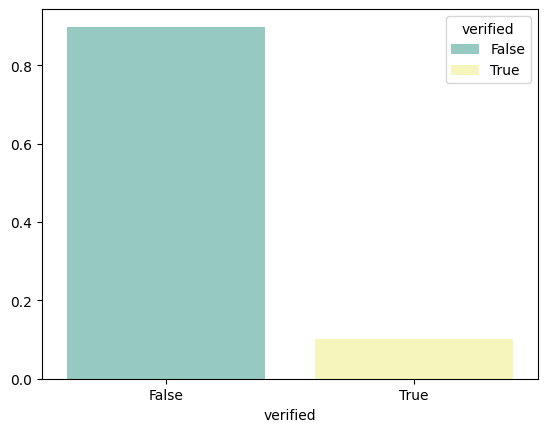

In [1301]:
#verified -> target
ax=sns.barplot(x=proportion_verified.index, y=proportion_verified.values, palette="Set3", hue=proportion_verified.index, legend="auto" )

**We have an imbalanced dataset on target** -> majority of extensions are not breached

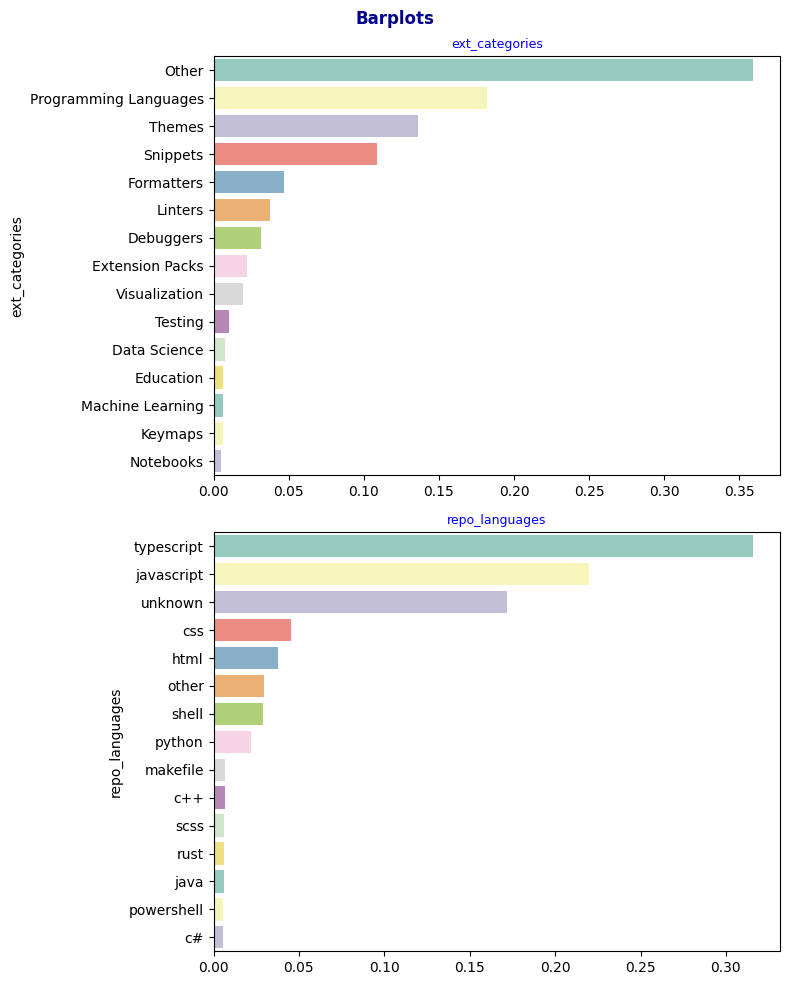

In [1302]:
fig, axes = plt.subplots(nrows = len(cols_cat), ncols = 1, figsize = (8, 10))
axes = axes.flat

for i,col in enumerate(df[cols_cat]):
    proportion_common = df[col].value_counts(normalize=True).head(15)
    sns.barplot(y=proportion_common.index,
                x=proportion_common.values,
                palette="Set3",
                hue=proportion_common.index,
                legend="auto",
                ax=axes[i] )
    
    axes[i].set_title(f"{col}", fontsize = 9, color = "blue")
    axes[i].set_xlabel("")

fig.suptitle("Barplots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


_Insight_:

### Numerical variables

**Quantitative:**

- Measurment of central tendency/dispersion

In [1303]:
df.describe()

,ext_version,ext_install_count,ext_rating,total_vulners,critical_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks
count,3.792900e+04,3.792900e+04,37929.000000,37929.000000,37929.0,37929.000000,37929.000000,37929.000000,37929.000000,37929.000000
mean,5.508504e+02,4.968202e+05,2.750174,1.697066,0.0,0.155343,0.790424,0.751298,415.417807,66.702734
std,1.036739e+05,6.300951e+06,2.363453,12.642718,0.0,1.868902,7.311949,6.340346,6019.072547,1239.617970
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,5.150000e+02,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000e+00,2.174000e+03,4.170000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000,1.000000
75%,1.000000e+00,1.187800e+04,5.000000,0.000000,0.0,0.000000,0.000000,0.000000,18.000000,4.000000
max,2.019083e+07,1.778445e+08,5.000000,402.000000,0.0,92.000000,230.000000,323.000000,199089.000000,57209.000000


In [1304]:
for col in cols_num:

    print("==" * 20)
    print(f"Variable: {col}\n")

    print("--" * 20)
    print(f"Measurements of central tendency:")
    print("--" * 20)
    print(f"Mean = {df[col].mean()}")
    print(f"Median = {df[col].median()}")
    print(f"Mode = {df[col].mode()}")
    print(f"\n")
    print("--" * 20)
    print(f"Measurements of central tendency:")
    print("--" * 20)
    print(f"Var = {df[col].var()}")
    print(f"Standard = {df[col].std()}")
    print(f"Min = {df[col].min()}")
    print(f"Max = {df[col].max()}")
    print(f"Range = {df[col].max()-df[col].min()}")

    print("==" * 20)
    print ()
    

Variable: ext_version

----------------------------------------
Measurements of central tendency:
----------------------------------------
Mean = 550.850351973424
Median = 0.0
Mode = 0    0
Name: ext_version, dtype: int64


----------------------------------------
Measurements of central tendency:
----------------------------------------
Var = 10748268147.547474
Standard = 103673.85469609719
Min = 0
Max = 20190831
Range = 20190831

Variable: ext_install_count

----------------------------------------
Measurements of central tendency:
----------------------------------------
Mean = 496820.24066018086
Median = 2174.0
Mode = 0    76
Name: ext_install_count, dtype: int64


----------------------------------------
Measurements of central tendency:
----------------------------------------
Var = 39701980806012.6
Standard = 6300950.785874509
Min = 1
Max = 177844528
Range = 177844527

Variable: ext_rating

----------------------------------------
Measurements of central tendency:
--------------

_Insight_:

- Shape of distribution

In [1305]:
for column in cols_num:
    skewness_col = df[column].skew()
    kurtosis_col = df[column].kurtosis()

    print("==" * 20)
    print(f"Variable: {column}\n")
    print(f"Skew = {skewness_col}")
    print(f"Kurtosis = {kurtosis_col}")
    print("==" * 20)

    print ()

Variable: ext_version

Skew = 194.7521475734619
Kurtosis = 37928.59917785546

Variable: ext_install_count

Skew = 20.357866421186483
Kurtosis = 482.98152359857113

Variable: ext_rating

Skew = -0.2459120769083387
Kurtosis = -1.86777696551205

Variable: total_vulners

Skew = 18.78137237994935
Kurtosis = 442.80695851778387

Variable: critical_vulners

Skew = 0.0
Kurtosis = 0.0

Variable: high_vulners

Skew = 32.07599442322883
Kurtosis = 1326.1371958675436

Variable: medium_vulners

Skew = 22.433168590469993
Kurtosis = 597.5803984435113

Variable: low_vulners

Skew = 29.017444932016332
Kurtosis = 1280.5255694927569

Variable: repo_stars

Skew = 26.719037352868444
Kurtosis = 771.7525261929592

Variable: repo_forks

Skew = 33.89351624442343
Kurtosis = 1261.0045036369042



_Insight_:

- Statistical test: use K-S  test and not Shapiro due to large dataset

In [1306]:
# standardized_saleprice = (df['SalePrice'] - df['SalePrice'].mean()) / df['SalePrice'].std()
# ks_test_statistic, ks_p_value = kstest(standardized_saleprice, 'norm')

# ks_test_statistic, ks_p_value

# print the test result


for col in cols_num:
    standardized = (df[col] - df[col].mean()) / df[col].std()
    ks_test_statistic, ks_p_value = kstest(standardized, 'norm')
    print("==" * 20)
    print(f"Variable: {col}\n")
    print(f"Test statistic = {ks_test_statistic: .2f}")
    print(f"p_value = {ks_p_value: .2f}")
    print("\n")
    if ks_p_value < 0.05:
        print(f"The distribution of '{col}' is significantly different from a normal distribution.")
    else:
        print(f"The distribution of '{col}'is NOT significantly different from a normal distribution.")

Variable: ext_version

Test statistic =  0.50
p_value =  0.00


The distribution of 'ext_version' is significantly different from a normal distribution.
Variable: ext_install_count

Test statistic =  0.47
p_value =  0.00


The distribution of 'ext_install_count' is significantly different from a normal distribution.
Variable: ext_rating

Test statistic =  0.29
p_value =  0.00


The distribution of 'ext_rating' is significantly different from a normal distribution.
Variable: total_vulners

Test statistic =  0.45
p_value =  0.00


The distribution of 'total_vulners' is significantly different from a normal distribution.
Variable: critical_vulners

Test statistic =  nan
p_value =  nan


The distribution of 'critical_vulners'is NOT significantly different from a normal distribution.
Variable: high_vulners

Test statistic =  0.50
p_value =  0.00


The distribution of 'high_vulners' is significantly different from a normal distribution.
Variable: medium_vulners

Test statistic =  0.46
p_valu

**Visual/Qualitative:**

- Histplot: display the frequency distribution of a dataset. The height of each bar represents the number of data points in each bin.

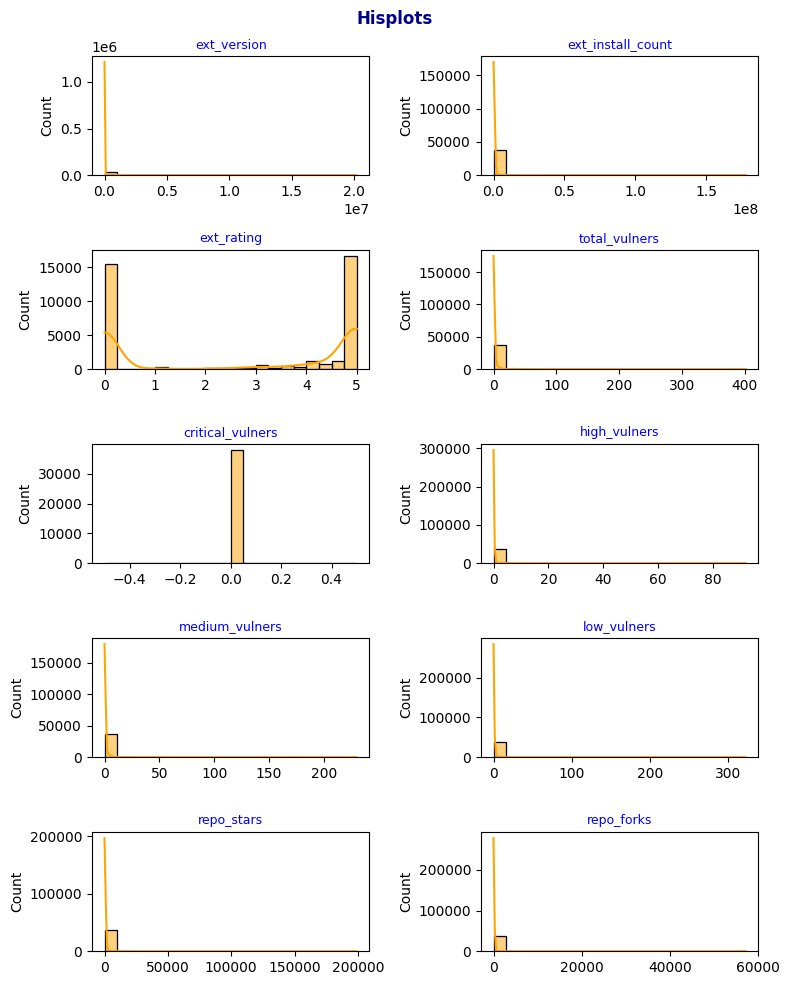

In [1307]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8, 10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sns.histplot(df[col],
                 kde=True,
                 bins=20,
                 color="orange",
                 ax=axes[i])    
    
    axes[i].set_title(f"{col}", fontsize = 9, color = "blue")
    axes[i].set_xlabel("")

fig.suptitle("Hisplots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

_Insight_:

- Histogram

In [1308]:
# df[cols_num].hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10);

- Boxplot/Whisker plot: showcase the central 50% of the data (interquartile range), potential outliers, and other statistical properties.

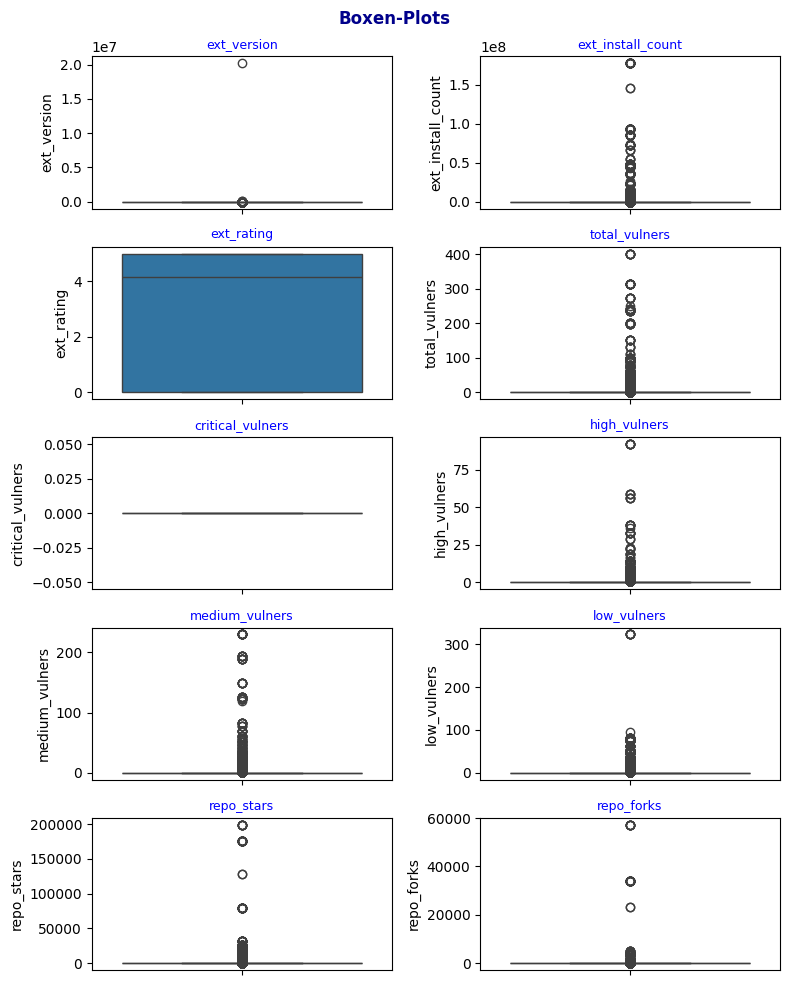

In [1309]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sns.boxplot(y = df[col],
                ax = axes[i])
    # sns.boxenplot(y=df[col],
    #               ax = axes[i])
    
    axes[i].set_title(f"{col}", fontsize = 9, color = "blue")
    axes[i].set_xlabel('')

fig.suptitle("Boxen-Plots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

_Insight_:

- QQ-Plot: visualize to help us assess if a dataset follows a particular theoretical distribution/ normal distribution

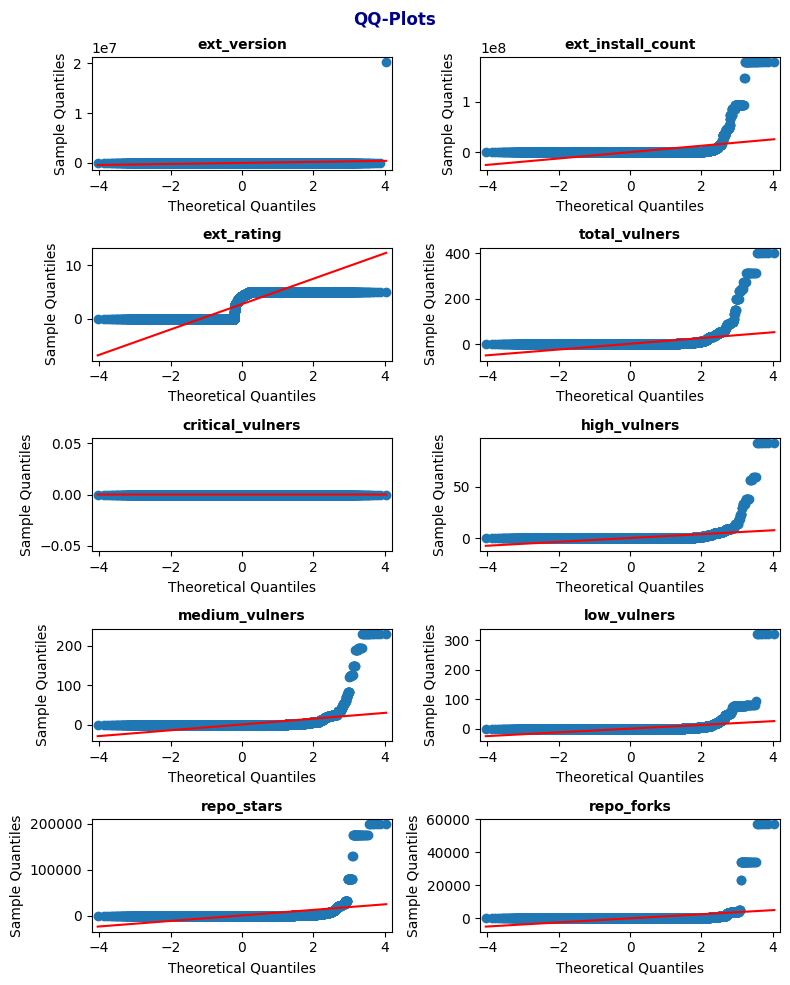

In [1310]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sm.qqplot(df[col], 
           line = "s", 
           ax = axes[i])
    
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("QQ-Plots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


_Insight_:

In [1311]:
df_eda = df.copy()
df_eda.to_csv(config["data"]["clean"]["file_eda_cleaned"],index=False)

## **Bivariate Analysis**


#### Preparation

- Binning

In [1312]:
df["ext_rating"].value_counts(normalize=True).sort_index(ascending = False)

ext_rating
5.00    0.411110
4.99    0.000079
4.98    0.000290
4.97    0.000765
4.96    0.001424
          ...   
1.44    0.000053
1.33    0.000053
1.17    0.000132
1.00    0.006749
0.00    0.410926
Name: proportion, Length: 232, dtype: float64

In [1313]:
# # Discretizing 'ext_rating' into 3 categories
bins = [0, 1, 4, df["ext_rating"].max()]
labels = [0, 1, 2]
df["ext_rating_category"] = pd.cut(df["ext_rating"], bins=bins, labels=labels, include_lowest=True)
df["ext_rating_category"].value_counts(normalize=True)

ext_rating_category
2    0.505365
0    0.417675
1    0.076960
Name: proportion, dtype: float64

In [1314]:
# # # Discretizing 'ext_rating' into 3 categories
# bins = [0, 1, 4, df["ext_rating"].max()]
# labels = ["0", "1 - 3", "4 and above"]
# df["ext_rating_category"] = pd.cut(df["ext_rating"], bins=bins, labels=labels, include_lowest=True)
# df["ext_rating_category"].value_counts(normalize=True)

In [1315]:
df["ext_version"].value_counts(normalize=True).sort_index(ascending = True)

ext_version
0           0.548894
1           0.325767
2           0.066545
3           0.023913
4           0.008727
5           0.003770
6           0.002004
7           0.001714
8           0.002188
9           0.001134
10          0.001055
11          0.000185
12          0.000264
13          0.000105
16          0.000422
17          0.000422
18          0.000554
19          0.000633
20          0.000343
21          0.000105
23          0.000923
24          0.000211
25          0.000817
26          0.000026
27          0.000053
41          0.000105
44          0.000185
64          0.000079
88          0.000079
100         0.000105
103         0.000053
109         0.000158
1001        0.000369
2002        0.000211
2018        0.000026
2019        0.000026
2020        0.000079
2021        0.000053
2022        0.000316
2023        0.001028
2024        0.000976
2025        0.005088
2026        0.000211
21300       0.000053
20190831    0.000026
Name: proportion, dtype: float64

In [1316]:
# Discretizing 'ext_version' into 3 categories

bins = [0, 1, 2, df["ext_version"].max()]
labels = [0, 1, 2]
df["ext_version_category"] = pd.cut(df["ext_version"], bins=bins, labels=labels, include_lowest=True)
df["ext_version_category"].value_counts(normalize=True)

ext_version_category
0    0.874661
1    0.066545
2    0.058794
Name: proportion, dtype: float64

In [1317]:
# # Discretizing 'ext_version' into 3 categories

# bins = [0, 1, 2, df["ext_version"].max()]
# labels = ["0", "1", "2 and above"]
# df["ext_version_category"] = pd.cut(df["ext_version"], bins=bins, labels=labels, include_lowest=True)
# df["ext_version_category"].value_counts(normalize=True)

In [1318]:
cols_cat, cols_num

(['ext_categories', 'repo_languages'],
 ['ext_version',
  'ext_install_count',
  'ext_rating',
  'total_vulners',
  'critical_vulners',
  'high_vulners',
  'medium_vulners',
  'low_vulners',
  'repo_stars',
  'repo_forks'])

In [1319]:
potential_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20].columns.to_list()
potential_categorical_from_numerical

['critical_vulners']

From Univariate Analysis, we observe that the "critical_vulners" has only one value 0
- We remove the column "critical_vulners" to avoid overfitting and further irrelevant analysis. 
- We remove "ext\_rating", "ext\_version" after binning

In [1320]:
df = df.drop(columns = ["ext_rating", "ext_version", "critical_vulners"])

In [1321]:

cols_num = df.select_dtypes(include = ["float","int"]).columns.to_list()
cols_cat = df.select_dtypes(include = ["object","category"]).columns.to_list()
cols_num, cols_cat

(['ext_install_count',
  'total_vulners',
  'high_vulners',
  'medium_vulners',
  'low_vulners',
  'repo_stars',
  'repo_forks'],
 ['ext_categories',
  'repo_languages',
  'ext_rating_category',
  'ext_version_category'])

In [1322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37929 entries, 0 to 19552
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ext_categories        37929 non-null  object  
 1   ext_install_count     37929 non-null  int64   
 2   verified              37929 non-null  bool    
 3   total_vulners         37929 non-null  int64   
 4   high_vulners          37929 non-null  int64   
 5   medium_vulners        37929 non-null  int64   
 6   low_vulners           37929 non-null  int64   
 7   repo_stars            37929 non-null  int64   
 8   repo_forks            37929 non-null  int64   
 9   repo_languages        37929 non-null  object  
 10  ext_rating_category   37929 non-null  category
 11  ext_version_category  37929 non-null  category
dtypes: bool(1), category(2), int64(7), object(2)
memory usage: 3.0+ MB


### Outliers:

**Outliers detection**

In [1323]:
df["ext_install_count"].dtype

dtype('int64')

In [1324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37929 entries, 0 to 19552
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ext_categories        37929 non-null  object  
 1   ext_install_count     37929 non-null  int64   
 2   verified              37929 non-null  bool    
 3   total_vulners         37929 non-null  int64   
 4   high_vulners          37929 non-null  int64   
 5   medium_vulners        37929 non-null  int64   
 6   low_vulners           37929 non-null  int64   
 7   repo_stars            37929 non-null  int64   
 8   repo_forks            37929 non-null  int64   
 9   repo_languages        37929 non-null  object  
 10  ext_rating_category   37929 non-null  category
 11  ext_version_category  37929 non-null  category
dtypes: bool(1), category(2), int64(7), object(2)
memory usage: 3.0+ MB


**Outliers handle**

- Delete observations->  not gonna use it

- Impute/Replace outliers using lower_bound, upper_bound

In [1325]:

for col in cols_num:
    outliers, lower_bound, lower_outliers_indexes, upper_bound, upper_outliers_indexes = detect_iqr_outliers(df, col, 0.25, 0.75)
    # outliers, lower_bound, lower_outliers_indexes, upper_bound, upper_outliers_indexes = detect_winsor_outliers(df, col, 5, 95)
    if outliers.shape[0] > 0:
        df.iloc[outliers.index, df.columns.get_loc(col)] = df[col].median()
        # df.iloc[lower_outliers_indexes,df.columns.get_loc(col)] = lower_bound
        # df.iloc[upper_outliers_indexes,df.columns.get_loc(col)] = upper_bound




Distribution of cols_num after replace outliers

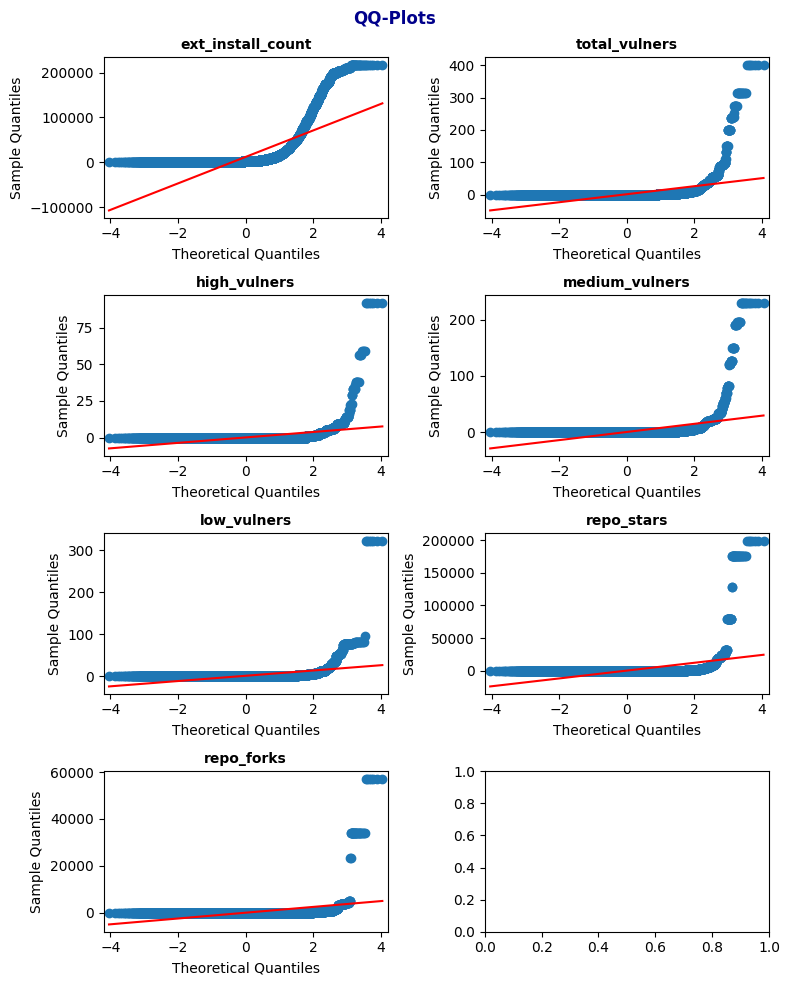

In [1326]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):  
    sm.qqplot(df[col], 
           line = "s", 
           ax = axes[i])
    
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("QQ-Plots", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

In [1327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37929 entries, 0 to 19552
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ext_categories        37929 non-null  object  
 1   ext_install_count     37929 non-null  int64   
 2   verified              37929 non-null  bool    
 3   total_vulners         37929 non-null  int64   
 4   high_vulners          37929 non-null  int64   
 5   medium_vulners        37929 non-null  int64   
 6   low_vulners           37929 non-null  int64   
 7   repo_stars            37929 non-null  int64   
 8   repo_forks            37929 non-null  int64   
 9   repo_languages        37929 non-null  object  
 10  ext_rating_category   37929 non-null  category
 11  ext_version_category  37929 non-null  category
dtypes: bool(1), category(2), int64(7), object(2)
memory usage: 3.0+ MB


- _Transform: after univariate or bivariate ?!! Experiment_

In [1328]:
# # #Log-transform
# for col in cols_num:
#     df[col] = np.log1p(df[col])

In [1329]:
#Square transform
# for col in cols_num:
#     df[col] = np.sqrt(df[col])

In [1330]:
# Box-Cox transform to columns with high skewness and positive values.

# for col in cols_num:
#     df[col], _ = boxcox(df[col])

In [1331]:
# Power transform
# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer()

# features = df.drop(columns = ["verfied"])
# target = df["verfied"]

# X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.20, random_state=0)
# X_train_num  = X_train.select_dtypes(include=['number'])
# pt.fit(X_train_num)
# X_test_num  = X_test.select_dtypes(include=['number'])

# X_train_trans = pt.transform(X_train_num)
# X_test_trans = pt.transform(X_test_num)
# X_train_trans = pd.DataFrame(X_train_trans, columns=X_train_num.columns, index=X_train_num.index )
# X_test_trans = pd.DataFrame(X_test_trans, columns=X_test_num.columns, index=X_test_num.index )

# sm.qqplot(X_train_trans['age'].values, fit=True, line='45')



- Distribution of cols_num after transforming values

In [ ]:
# fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
# axes = axes.flat

# for i,col in enumerate(cols_num):
#     sm.qqplot(df[col], 
#            line = "s", 
#            ax = axes[i])
    
#     axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# # fig.delaxes(axes[7])
# fig.suptitle("QQ-Plots", fontsize = 12, fontweight = "bold", color = "darkblue")
# fig.tight_layout()
# fig.show()

In [1333]:
df

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
0,Programming Languages,2174,True,0,0,0,0,3,1,typescript,2,2
0,Programming Languages,2174,True,0,0,0,0,3,1,python,2,2
0,Programming Languages,2174,True,0,0,0,0,3,1,javascript,2,2
0,Programming Languages,2174,True,0,0,0,0,3,1,jupyter notebook,2,2
0,Programming Languages,2174,True,0,0,0,0,4461,1,shell,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
19550,Other,3,False,0,0,0,0,42,6,javascript,0,0
19550,Other,3,False,0,0,0,0,42,6,shell,0,0
19551,Other,2,False,0,0,0,0,1,1,typescript,0,0
19552,Other,1,True,1,1,0,0,3,0,typescript,0,0


#### Categorical vs Categorical

Quantitative

- Chi-Square: determine whether there is a significant association between two categorical variables

In [1334]:
ct_results = {}
# ct_results_common = {}
for col in cols_cat:
    # if df[col].nunique() <= 10: 
        # result = pd.crosstab(df[col], df["verified"])        
    # else:
    #     result = pd.crosstab(df[col].value_counts().head(10), df["verified"])    
    result = pd.crosstab(df[col], df["verified"])    
    ct_results[col] = result

In [1335]:
for col in cols_cat:
    crosstab_result = ct_results[col]
    chi2_statistic, chi2_p_value, _, expected_freq = chi2_contingency(crosstab_result)
    # pd.DataFrame(expected_freq, columns=df["verified"].unique(), index=crosstab_result.index)
    print("==" * 20)
    print(f"Variable: {col}\n")
    print(f"Test statistic = {chi2_statistic: .2f}")
    print(f"p_value = {chi2_p_value: .2f}")

    if chi2_p_value < 0.05:
        print(f"There is significant association between the categorical variables '{col}' and 'verified'.")
    else:
        print(f"There is not enough evidence to conclude a significant association between the variables '{col}' and 'verified'.")

Variable: ext_categories

Test statistic =  2901.51
p_value =  0.00
There is significant association between the categorical variables 'ext_categories' and 'verified'.
Variable: repo_languages

Test statistic =  1512.93
p_value =  0.00
There is significant association between the categorical variables 'repo_languages' and 'verified'.
Variable: ext_rating_category

Test statistic =  1099.22
p_value =  0.00
There is significant association between the categorical variables 'ext_rating_category' and 'verified'.
Variable: ext_version_category

Test statistic =  856.56
p_value =  0.00
There is significant association between the categorical variables 'ext_version_category' and 'verified'.


In [1336]:
for col1 in cols_cat:
    for col2 in cols_cat:
        if col2 != col1:
            crosstab_result = crosstab_result = pd.crosstab(df[col2], df[col1])
            chi2_statistic, chi2_p_value, _, expected_freq = chi2_contingency(crosstab_result)

            print("==" * 20)
            print(f"Variable: {col2} and {col1}\n")
            print(f"Test statistic = {chi2_statistic: .2f}")
            print(f"p_value = {chi2_p_value: .2f}")

            if chi2_p_value < 0.05:
                print(f"There is significant association between the categorical variables {col2} and {col1}.")
            else:
                print(f"There is not enough evidence to conclude a significant association between the variables {col2} and {col1}.")

Variable: repo_languages and ext_categories

Test statistic =  19474.01
p_value =  0.00
There is significant association between the categorical variables repo_languages and ext_categories.
Variable: ext_rating_category and ext_categories

Test statistic =  1139.64
p_value =  0.00
There is significant association between the categorical variables ext_rating_category and ext_categories.
Variable: ext_version_category and ext_categories

Test statistic =  965.86
p_value =  0.00
There is significant association between the categorical variables ext_version_category and ext_categories.
Variable: ext_categories and repo_languages

Test statistic =  19474.01
p_value =  0.00
There is significant association between the categorical variables ext_categories and repo_languages.
Variable: ext_rating_category and repo_languages

Test statistic =  1279.53
p_value =  0.00
There is significant association between the categorical variables ext_rating_category and repo_languages.
Variable: ext_version_

- Cramer-V: quantify the strength of the relationship between categorical variables*

In [1337]:
for col in cols_cat:
    # crosstab_result = pd.crosstab(df[col], df["verified"])
    crosstab_result = ct_results[col]
    association_result = association(crosstab_result, method="cramer")

    print("==" * 20)
    print(f"Variable: {col}\n")
    print(f"Assocation = {association_result: .2f}")
    
    if association_result == 0:
        print(f"There is No association between the categorical variables '{col}' and 'verified'.")
    elif association_result == 1:
        print(f"There is a Perfect  association between the categorical variables '{col}' and 'verified'.")
    elif association_result < 0.5 and association_result > 0:
        print(f"There is a Medium association between the categorical variables '{col}' and 'verified'.")
    elif association_result > 0.5 and association_result < 1:
        print(f"There is a Strong association between the categorical variables '{col}' and 'verified'.")

Variable: ext_categories

Assocation =  0.28
There is a Medium association between the categorical variables 'ext_categories' and 'verified'.
Variable: repo_languages

Assocation =  0.20
There is a Medium association between the categorical variables 'repo_languages' and 'verified'.
Variable: ext_rating_category

Assocation =  0.17
There is a Medium association between the categorical variables 'ext_rating_category' and 'verified'.
Variable: ext_version_category

Assocation =  0.15
There is a Medium association between the categorical variables 'ext_version_category' and 'verified'.


In [1338]:
for col1 in cols_cat:
    for col2 in cols_cat:
        if col2 != col1:
            crosstab_result = crosstab_result = pd.crosstab(df[col2], df[col1])
            association_result = association(crosstab_result, method="cramer")

            print("==" * 20)
            print(f"Variable: {col2} and {col1}\n")
            print(f"Assocation = {association_result: .2f}")

            if association_result == 0:
                print(f"There is No association between the categorical variables '{col2}' and '{col1}'.")
            elif association_result == 1:
                print(f"There is a Perfect  association between the categorical variables '{col2}' and '{col1}'.")
            elif association_result < 0.5 and association_result > 0:
                print(f"There is a Medium association between the categorical variables '{col2}' and '{col1}'.")
            elif association_result > 0.5 and association_result < 1:
                print(f"There is a Strong association between the categorical variables '{col2}' and '{col1}'.")
           
        

Variable: repo_languages and ext_categories

Assocation =  0.16
There is a Weak association between the categorical variables 'repo_languages' and 'ext_categories'.
Variable: ext_rating_category and ext_categories

Assocation =  0.12
There is a Weak association between the categorical variables 'ext_rating_category' and 'ext_categories'.
Variable: ext_version_category and ext_categories

Assocation =  0.11
There is a Weak association between the categorical variables 'ext_version_category' and 'ext_categories'.
Variable: ext_categories and repo_languages

Assocation =  0.16
There is a Weak association between the categorical variables 'ext_categories' and 'repo_languages'.
Variable: ext_rating_category and repo_languages

Assocation =  0.13
There is a Weak association between the categorical variables 'ext_rating_category' and 'repo_languages'.
Variable: ext_version_category and repo_languages

Assocation =  0.17
There is a Weak association between the categorical variables 'ext_versio

Visuals/Qualitative

- Stacked barcharts
- Grouped barcharts

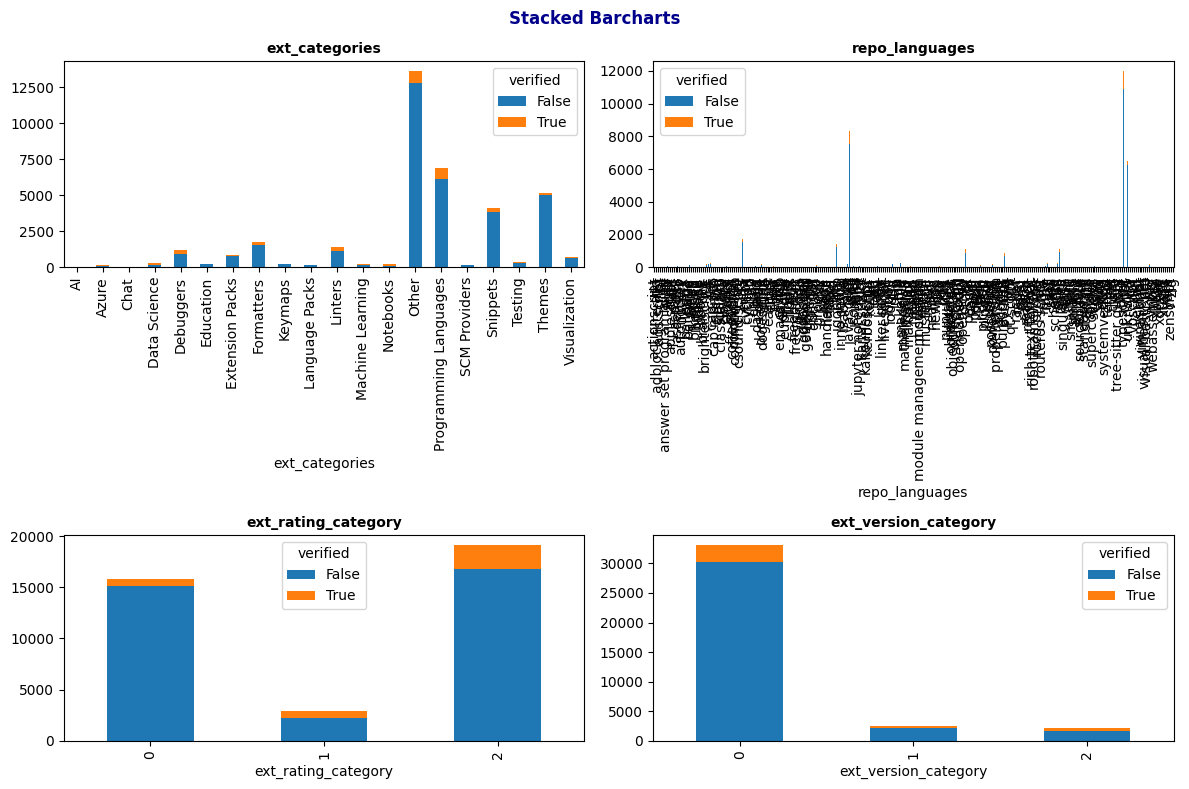

In [1339]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_cat)/2)), ncols = 2, figsize = (12,8))
axes = axes.flat

for i,col in enumerate(cols_cat):
    crosstab_result = ct_results[col]
    crosstab_result.plot(kind="bar",
                         stacked=True,
                         ax = axes[i]);
    # sns.countplot(data=df,
    #               x=col,
    #               hue='verified',
    #               ax = axes[i]);
    
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("Stacked Barcharts", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

- Heatmap

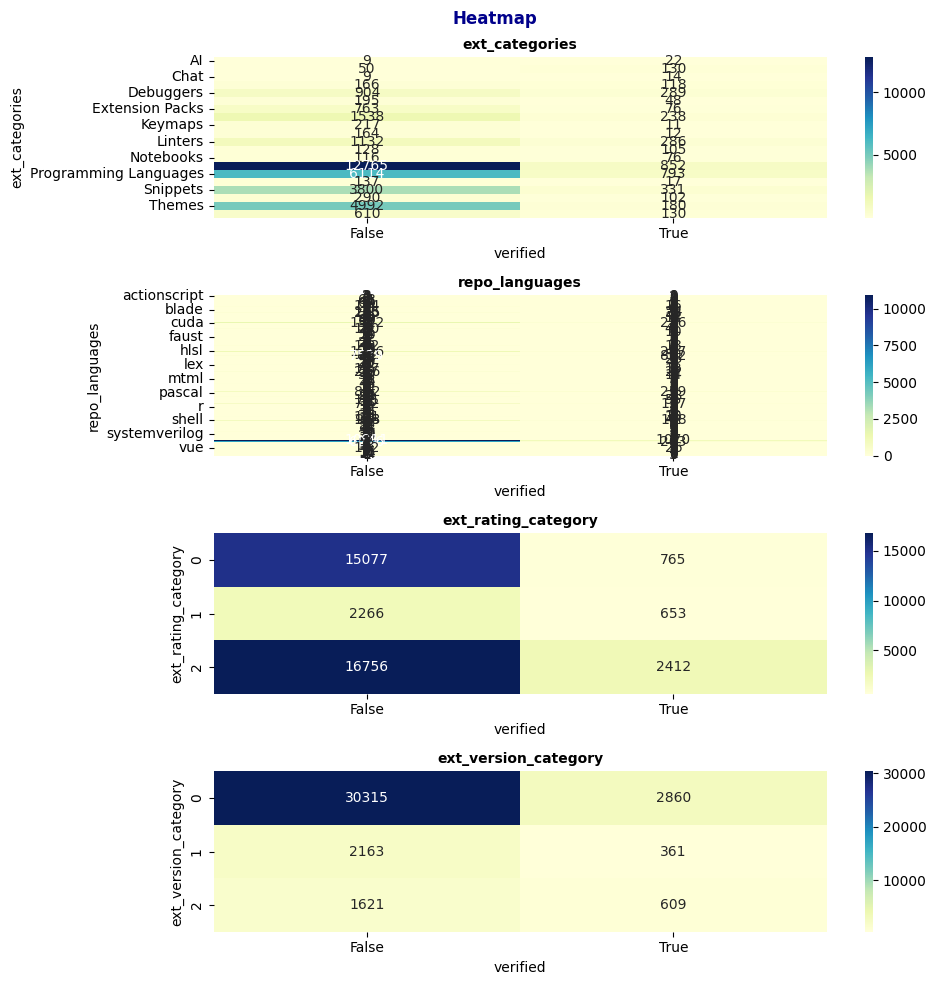

In [1340]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_cat))), ncols = 1, figsize = (10,10))
axes = axes.flat

for i,col in enumerate(cols_cat):
    crosstab_result = ct_results[col]
    sns.heatmap(crosstab_result,
                annot=True,
                cmap="YlGnBu",
                fmt="d",
                ax = axes[i]);
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("Heatmap", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


#### Categorical vs Numerical

Quantitative

- ANNOVA Test

In [1341]:
cols_num 

['ext_install_count',
 'total_vulners',
 'high_vulners',
 'medium_vulners',
 'low_vulners',
 'repo_stars',
 'repo_forks']

In [1342]:
df_breached = df[df["verified"] == True][cols_num]
df_no_df_breached = df[df["verified"] == False][cols_num]

#Set the hypothesis

#H0: df_breached = df_no_df_breached
#H1: df_breached != df_no_df_breached

alpha = 0.05

Statistic_result, p_value = st.f_oneway(df_breached, df_no_df_breached)
p_value
for i in range(len(cols_num)):
    print("==" * 20)
    print(f"Variable: {cols_num[i]}\n")
    print(f"Statistic test = {Statistic_result[i]: .2f}")
    print(f"p_value = {p_value[i]: .2f}")

    if p_value[i] < alpha:
        print(f"Reject the hypothesis.")
    else:
        print(f"There is not enough evidence to conclude a significant association between the variables '{col}' and 'verified'.")

Variable: ext_install_count

Statistic test =  684.38
p_value =  0.00
Reject the hypothesis.
Variable: total_vulners

Statistic test =  151.21
p_value =  0.00
Reject the hypothesis.
Variable: high_vulners

Statistic test =  3.36
p_value =  0.07
There is not enough evidence to conclude a significant association between the variables 'ext_version_category' and 'verified'.
Variable: medium_vulners

Statistic test =  42.64
p_value =  0.00
Reject the hypothesis.
Variable: low_vulners

Statistic test =  322.59
p_value =  0.00
Reject the hypothesis.
Variable: repo_stars

Statistic test =  82.27
p_value =  0.00
Reject the hypothesis.
Variable: repo_forks

Statistic test =  2.46
p_value =  0.12
There is not enough evidence to conclude a significant association between the variables 'ext_version_category' and 'verified'.


Visuals/Qualitative

- Grouped boxplots
- Grouped Violinplots

    a. Category "verified"

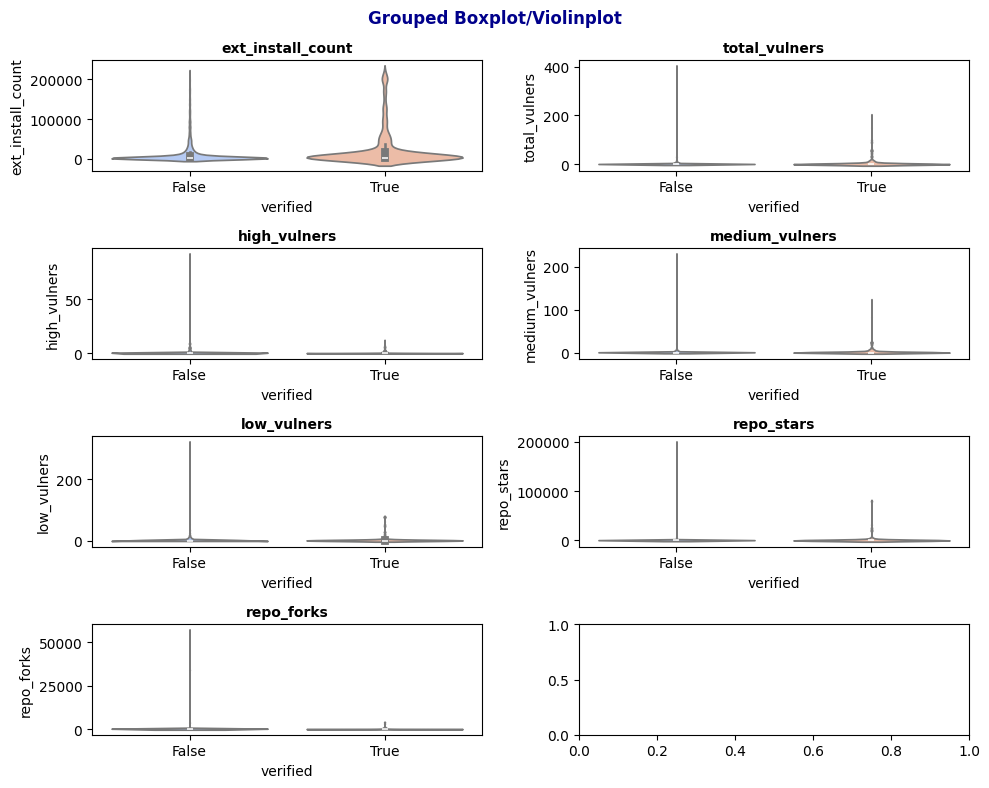

In [1343]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (10,8))
axes = axes.flat

for i,col in enumerate(cols_num):
    # sns.boxplot(data=df, 
    #             x='verified',
    #             y=col, 
    #             palette="coolwarm",
    #             hue='verified',
    #             legend=False,
    #             ax = axes[i]);
    
    sns.violinplot(data=df, 
                x='verified',
                y=col, 
                palette="coolwarm",
                hue='verified',
                legend=False,
                ax = axes[i]);
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("Grouped Boxplot/Violinplot", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

In [1344]:
df.head()

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
0,Programming Languages,2174,True,0,0,0,0,3,1,typescript,2,2
0,Programming Languages,2174,True,0,0,0,0,3,1,python,2,2
0,Programming Languages,2174,True,0,0,0,0,3,1,javascript,2,2
0,Programming Languages,2174,True,0,0,0,0,3,1,jupyter notebook,2,2
0,Programming Languages,2174,True,0,0,0,0,4461,1,shell,2,2


#### Numerical vs Numerical

Quantitative

- Correlation Pearson

In [1345]:
correlation_pearson = df[cols_num].corr()



- Correlation Spearman

In [1346]:
correlation_spearman = df[cols_num].corr(method='spearman')


Visuals/Qualitative

- Heatmap of correlation

Pearson

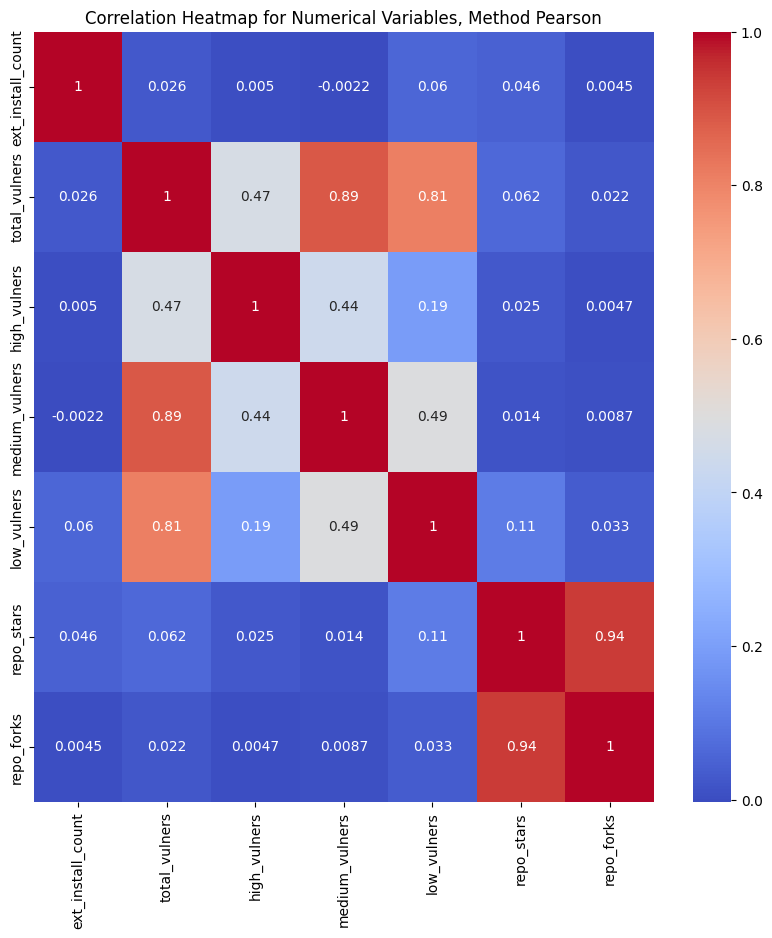

In [1347]:
plt.figure(figsize=(10, 10))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_pearson, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Numerical Variables, Method Pearson")
plt.show()

Spearman

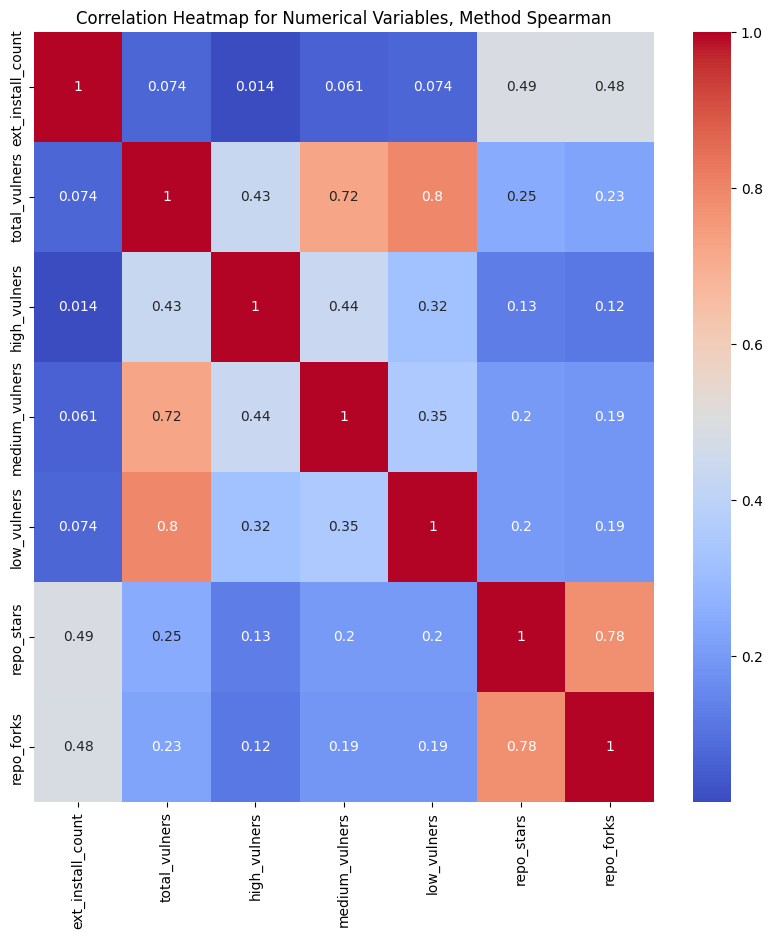

In [1348]:
plt.figure(figsize=(10, 10))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_spearman, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Numerical Variables, Method Spearman")
plt.show()

- Pairplot

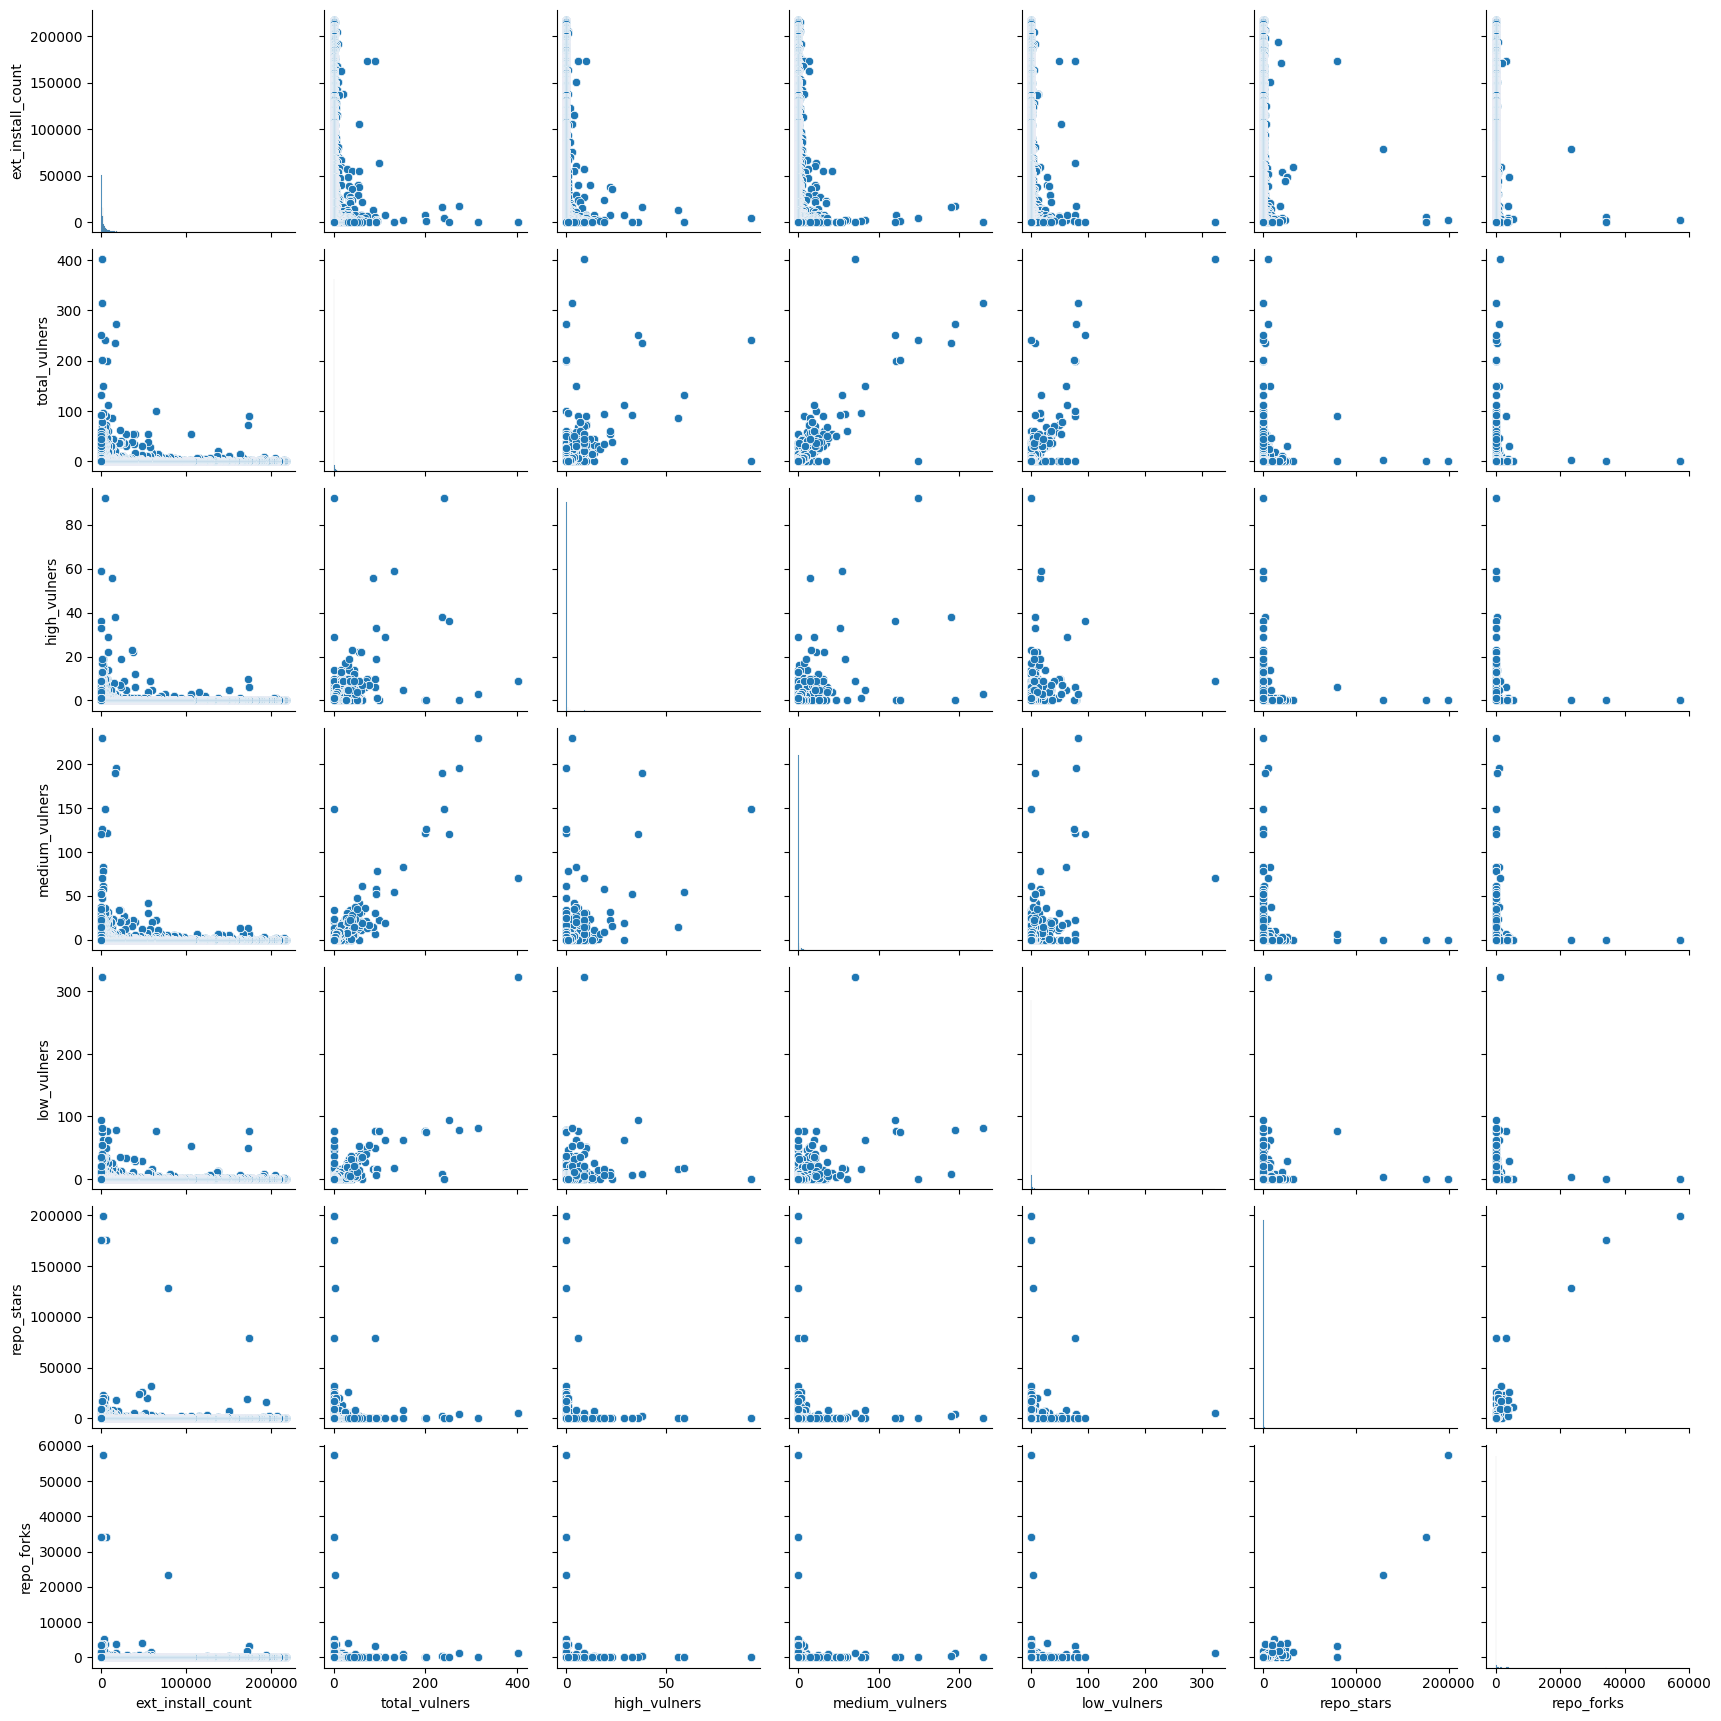

In [1349]:
sns.pairplot(df[cols_num]);

- Scatterplot

Variable: "repo_stars"

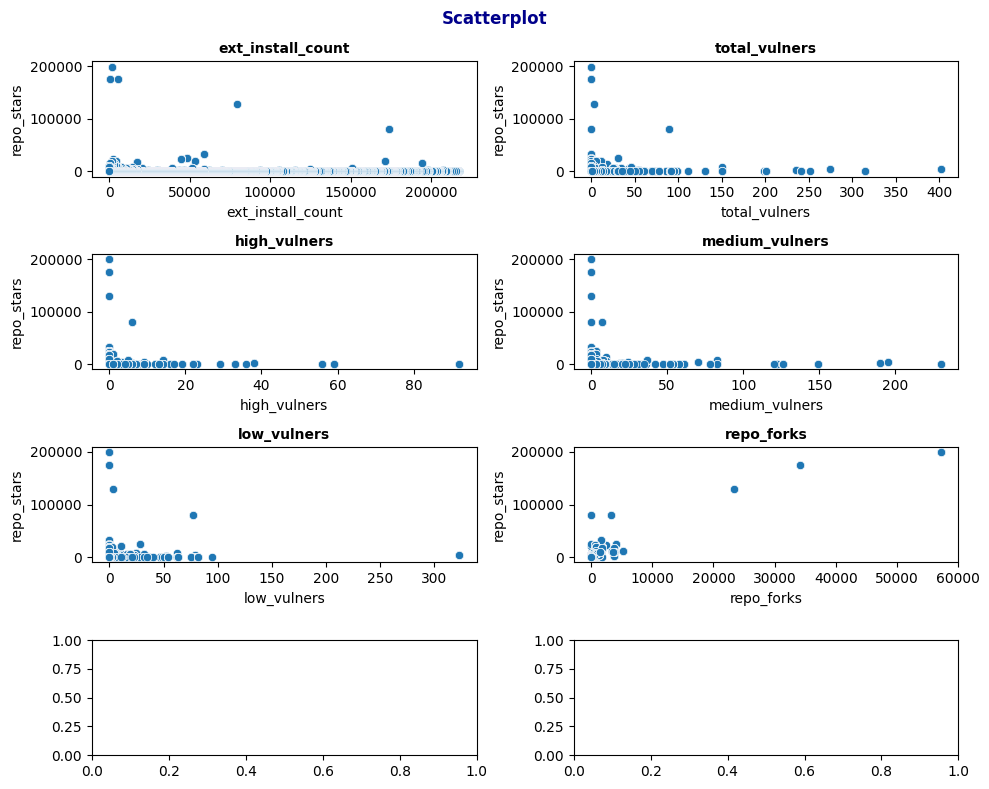

In [1350]:
# for col in cols_num:
#     plt.figure(figsize=(5, 5))
#     plt.title('Scatter plot of SalePrice vs ' + col)
#     sns.scatterplot(data=df, x=col, y='SalePrice')
#     plt.show()

fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (10,8))
axes = axes.flat

for i,col in enumerate(df[cols_num].drop(columns="repo_stars").columns):
    sns.scatterplot(data=df,
                    x=col,
                    y='repo_stars',
                    ax = axes[i]);
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("Scatterplot", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

Variable: "ext\_install\_count"

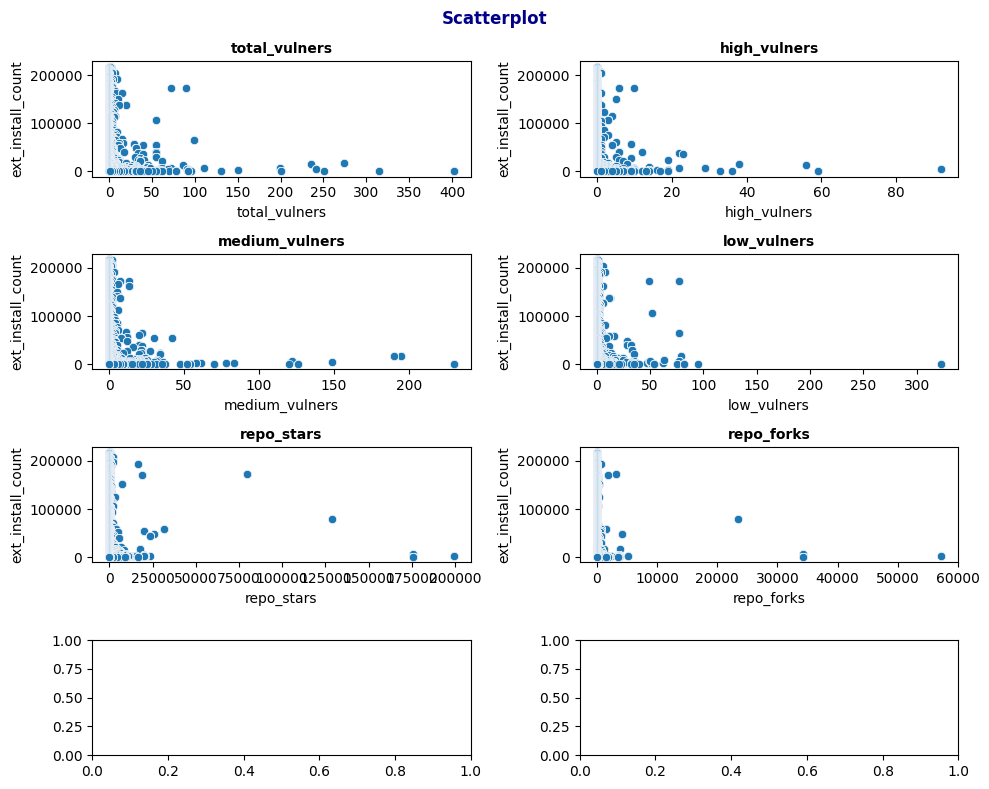

In [1351]:
# for col in cols_num:
#     plt.figure(figsize=(5, 5))
#     plt.title('Scatter plot of SalePrice vs ' + col)
#     sns.scatterplot(data=df, x=col, y='SalePrice')
#     plt.show()

fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (10,8))
axes = axes.flat

for i,col in enumerate(df[cols_num].drop(columns="ext_install_count").columns):
    sns.scatterplot(data=df,
                    x=col,
                    y='ext_install_count',
                    ax = axes[i]);
    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")
    
# fig.delaxes(axes[7])
fig.suptitle("Scatterplot", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

In [1352]:
df_eda = df.copy()
df_eda.to_csv(config["data"]["clean"]["file_eda_cleaned"],index=False)

**_We want low correlation between features, but high correlation between features and our target._**